# CheXNet: Classification of Thoracic Diseases From Chest X-ray Images

## Table of Contents
1. [Introduction and Setup](#introduction)
2. [Prepare the Dataset](#dataset)
3. [Create the Model](#model)
4. [Train the Model](#fine_tunng)
5. [Evaluate the Model](#evaluate)
7. [Inference Examples](#inference-examples)
6. [Training on Multiple Gaudis](#multi-gaudi)

<a id='Introduction'></a>
## Introduction

This notebook shows how to fine-tune [CheXNet](https://arxiv.org/abs/1711.05225v3) on a Gaudi system. CheXNet is a 121-layer DenseNet model trained on [ChestX-ray14](https://paperswithcode.com/dataset/chestx-ray14) dataset. It takes chest X-ray images as input and performs multi-label classification to detect 14 different thoracic diseases. 
The DenseNet121 backbone of this model is pretrained on the ImageNet dataset. We add a classification layer and use ChestX-ray14 dataset to fine-tune the model for this application.
We will show how easy and fast it is to train this model on a Gaudi system. We will also show how you can further accelerate the training using multiple Gaudis.

The following steps presented in this tutorial are summarized in this pipeline:

![pipeline.svg](pipeline.svg)

This notebook is meant to demonstrate the entire end-to-end model development process. 
However, for the sake of practicability, in what follows, we only cover training on a single Gaudi device.
The instructions for distributed trainig on multiple devices are provided in the last section.
In addition to this notebook, in the same directory you can find the `chexnet.py` script for training and inference, that includes performance calculation.

## Setup

This notebook runs on a Gaudi system with SynapseAI and Gaudi drivers installed. Please refer to the [installation guide](https://docs.habana.ai/en/latest/Installation_Guide/index.html) for more information.


### Install dependencies

In [ ]:
%pip install numpy Pillow scikit-learn pandas torch torchvision matplotlib tqdm

<a id='import'></a>
## Import Public Modules

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

### Import Habana-related Modules

In [2]:
from habana_frameworks.torch.utils.library_loader import load_habana_module
import habana_frameworks.torch.core as htcore
import habana_frameworks.torch.distributed.hccl

load_habana_module()
device = torch.device('hpu')

Loading Habana modules from /usr/local/lib/python3.8/dist-packages/habana_frameworks/torch/lib


<a id='dataset'></a>
## Prepare the Dataset 

ChestX-ray dataset comprises 112,120 frontal-view X-ray images of 30,805 unique patients with the text-mined fourteen disease image labels, where each image can have multi-labels. The thoracic pathologies covered in the data set are:
    
    1. Atelectasis
    2. Cardiomegaly
    3. Effusion
    4. Infiltration
    5. Mass
    6. Nodule
    7. Pneumonia
    8. Pneumothorax
    9. Consolidation
    10. Edema
    11. Emphysema
    12. Fibrosis
    13. Pleural_Thickening
    14. Hernia


The dataset is available at https://nihcc.app.box.com/v/ChestXray-NIHCC. Please download and extract the `images` folder as well as the `Data_Entry_2017_v2020.csv`, `train_val_list.txt`, and `test_list.txt` files to your working directory. 

Run the script `preprocess_data.py` to generate the split files with labels. This will create a new folder called `labels` which contains the `train_list.txt` and `test_list.txt`.

### Create the dataset class
In the cell below we use data primitive `torch.utils.data.Dataset` to create `ChestXrayData` class for loading and processing training and test data.

In [3]:
class ChestXrayData(torch.utils.data.Dataset):
    def __init__(self, data_dir, image_list_file, transform=None):
        '''
        data_dir: path to image directory.
        image_list_file: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        '''
        image_names = []
        labels = []
        with open(image_list_file, 'r') as f:
            for line in f:
                items = line.split()
                image_name = os.path.join(data_dir, items[0])
                image_names.append(image_name)
                label = [int(i) for i in items[1:]]
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        '''
        index: the index of item
        Return image and its labels
        '''
        return self.get_sample(index, self.transform)

    def get_sample(self, index, transform):
        '''
        index: the index of item
        transform: the transform used on item
        Return transformed image and its labels
        '''
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        
        if transform:
            image = transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

In the next step, we compose all image tranformations (resize, normalize, casting to tensor) together in `torchvision.transforms.Compose` class and pass it to ChestXrayData class.

In [4]:
# We assume the ChestX-ray14 dataset downloaded in local storage.
# ./images - directory containing image files
# ./labels - directory containing .txt files with list of image names and their respective
#            ground truth labels on every row

data_dir  = 'images'
label_dir = 'labels'

# Each line contains the filename of an x-ray image and respective labels
train_image_list_file = label_dir + '/train_list.txt'
test_image_list_file  = label_dir + '/test_list.txt'
batch_size            = 32

# preprocessing for visualization
resize_transform = transforms.Compose([
    transforms.Resize(256),                                     
    transforms.ToTensor()                                       
    ])

# preprocessing for model input
normalize_transform = transforms.Compose([
    resize_transform,                                       
    transforms.Normalize(                          
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
        )                                                    
    ])

# train data set object
train_data = ChestXrayData(
    data_dir=data_dir,                
    image_list_file=train_image_list_file,
    transform=normalize_transform,
    )

# batch by batch iterator on train data
train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    ) 

# test data set object
test_data = ChestXrayData(
    data_dir=data_dir,
    image_list_file=test_image_list_file,
    transform=normalize_transform,
    )

# batch by batch iterator on test data
test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    )

print('Train dataset contains %d batches and %d images' % (len(train_loader), len(train_data)))
print('Test dataset contains %d batches and %d images'  % (len(test_loader),  len(test_data)))

Train dataset contains 2704 batches and 86524 images
Test dataset contains 800 batches and 25596 images


Now, we create a list containing disease names to map image labels.

In [5]:
CLASS_COUNT = 14
CLASS_NAMES = [
    'Atelectasis',
    'Cardiomegaly',
    'Effusion',
    'Infiltration',
    'Mass',
    'Nodule',
    'Pneumonia',
    'Pneumothorax',
    'Consolidation',
    'Edema',
    'Emphysema',
    'Fibrosis',
    'Pleural_Thickening',
    'Hernia'
    ]

Let's visualize a few X-ray images with their disease labels.

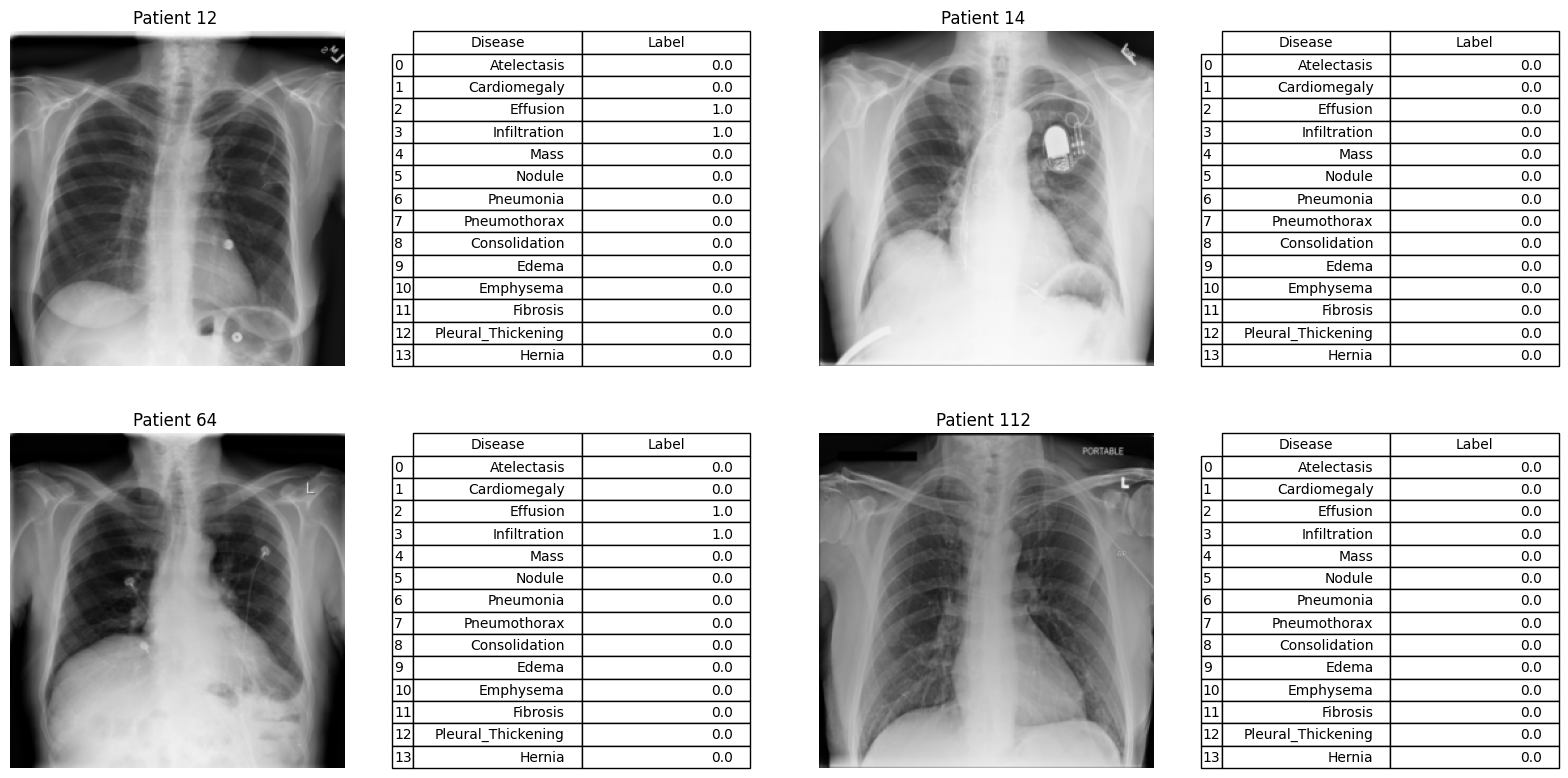

In [6]:
patient_id_list = [12, 14, 64, 112]    # arbitrary patient ids picked up for visualization

fig = plt.figure(figsize=(20, 20))

for plot_id, patient_id in enumerate(patient_id_list):
    image, label = train_data.get_sample(patient_id, resize_transform)
    print_img = np.transpose(image.numpy(), (1, 2, 0))
    y_true = label.numpy()
    df = pd.DataFrame({'Disease': CLASS_NAMES, 'Label': y_true})
    
    ax1 = fig.add_subplot(len(patient_id_list), len(patient_id_list), 2*plot_id+1)
    title = 'Patient %d ' % (patient_id)
    ax1.set_title(title)
    ax1.axis('off')
    plt.imshow(print_img)
    
    ax2 = fig.add_subplot(len(patient_id_list), len(patient_id_list), 2*plot_id+2)
    ax2.axis('off')
    table = ax2.table(cellText=df.values, rowLabels=df.index, bbox=[0, 0, 1, 1], colLabels=df.columns)
    table.set_fontsize(12)
    
plt.show()

<a id='model'></a>
## Create the Model

Here, we add a linear classification layer with 14 logit outputs (with no activation function) on the top of the `torchvision.models.densenet121` backbone model. Each classifier output represents a disease.

For the backbone initialization, we use the ImageNet weights from the checkpoint `torchvision.models.DenseNet121_Weights.IMAGENET1K_V1`.

In [7]:
class CheXNet(nn.Module):
    def __init__(self, out_size):
        super(CheXNet, self).__init__()
        self.densenet121 = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
        num_features = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Linear(num_features, out_size)

    def forward(self, x):
        x = self.densenet121(x)
        return x

<a id='fine_tunng'></a>
## Train the Model

Now, we perform transfer learning using the previously loaded weights as initial values for further fine-tuning with our dataset.

In [8]:
net = CheXNet(CLASS_COUNT)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

#### Imbalanced Training

In medical domain, we typically deal with imbalanced data, where negative datapoints by far exceed the positive ones in numbers of occurrence. To cope with that inherent imbalanced distribution, we need to quantify it. The following line calculates the prior odds over the training data for each disease. The users themselves can verify that the odds over the test data are very similar to the train data.

In [9]:
pos_weight = pd.read_csv(train_image_list_file, sep=' ', header=None, usecols=range(1, 1+CLASS_COUNT))\
    .apply(lambda x: (x.size - x.sum()) / x.sum())
pos_weight = torch.tensor(pos_weight.values).float().to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [10]:
num_epoch       = 50
log_window_size = 1000    # number of steps till next log
train_loss      = 0
accuracy        = 0
step            = 0

net.train()
for epoch in range(num_epoch):
    for (images, labels) in tqdm(train_loader, desc='Epoch %d/%d' %(epoch+1, num_epoch)):
        images = images.to(device)
        labels = labels.to(device)
        logits = net(images)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        htcore.mark_step()
        optimizer.step()
        htcore.mark_step()

        y_true = labels.detach().cpu()
        y_pred = (logits.detach().cpu() > 0.0).float()
        
        accuracy += ( accuracy_score( y_true.reshape(-1), y_pred.reshape(-1) ) ) * len(images) # weighted accuracy
        train_loss += loss.item() * len(images)
        if step % log_window_size == log_window_size - 1:
            count_window_datapoints = (log_window_size - 1) * batch_size + len(images)
            print(f'Loss: {train_loss / count_window_datapoints }, Accuracy: { accuracy / count_window_datapoints })')
            accuracy = 0
            train_loss = 0

        step += 1    

Epoch 1/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 1.2127280611395836, Accuracy: 0.6527455357142852)
Loss: 1.1665374150276184, Accuracy: 0.655334821428573)


Epoch 2/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 1.1195517661571504, Accuracy: 0.6629508928571417)
Loss: 1.0856945688426494, Accuracy: 0.7141986607142855)
Loss: 1.0469224134087562, Accuracy: 0.6944531249999999)


Epoch 3/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 1.0325227807313204, Accuracy: 0.7189151785714281)
Loss: 1.0043831191062926, Accuracy: 0.7397500000000009)
Loss: 0.9026988229602575, Accuracy: 0.7395133928571432)


Epoch 4/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 1.0101187621951104, Accuracy: 0.7277031250000002)
Loss: 0.9053398480117321, Accuracy: 0.7592321428571426)


Epoch 5/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.8259257456511259, Accuracy: 0.7621250000000009)
Loss: 0.8851600732803345, Accuracy: 0.7715357142857133)
Loss: 0.7868182998001575, Accuracy: 0.7783013392857142)


Epoch 6/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.7231213425248861, Accuracy: 0.8036741071428578)
Loss: 0.821124221354723, Accuracy: 0.7869642857142841)
Loss: 0.6672753602564335, Accuracy: 0.8068370535714283)


Epoch 7/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.6808273003846407, Accuracy: 0.8173214285714288)
Loss: 0.6705701777935028, Accuracy: 0.823104910714286)


Epoch 8/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.5756751181036234, Accuracy: 0.8304732142857145)
Loss: 0.596903548002243, Accuracy: 0.8453303571428581)
Loss: 0.5958878982365131, Accuracy: 0.8354799107142857)


Epoch 9/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.5250223059654235, Accuracy: 0.8536071428571425)
Loss: 0.5152493527382612, Accuracy: 0.8653906250000003)
Loss: 0.5037574940994382, Accuracy: 0.8557812499999999)


Epoch 10/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.49355342487245796, Accuracy: 0.8667254464285712)
Loss: 0.5234218653142452, Accuracy: 0.8654508928571425)
Loss: 0.526722657956183, Accuracy: 0.8489107142857146)


Epoch 11/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.4666927877292037, Accuracy: 0.8774107142857147)
Loss: 0.44869863268733023, Accuracy: 0.8801294642857148)


Epoch 12/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.4152488465681672, Accuracy: 0.879542410714286)
Loss: 0.36812676687538626, Accuracy: 0.9056473214285709)
Loss: 0.4422246888577938, Accuracy: 0.8775580357142864)


Epoch 13/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.35812406227737664, Accuracy: 0.9021830357142849)
Loss: 0.3568252422735095, Accuracy: 0.9076919642857144)
Loss: 0.3667188947126269, Accuracy: 0.8955178571428569)


Epoch 14/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.3731854792311788, Accuracy: 0.9023080357142864)
Loss: 0.34820389485359193, Accuracy: 0.9081517857142857)


Epoch 15/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.34834610084444284, Accuracy: 0.9001941964285711)
Loss: 0.31746950548142194, Accuracy: 0.9201383928571435)
Loss: 0.3239630596190691, Accuracy: 0.9119575892857132)


Epoch 16/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.30623081308975814, Accuracy: 0.9161651785714277)
Loss: 0.2959116340726614, Accuracy: 0.9245267857142863)
Loss: 0.3122432637773454, Accuracy: 0.9143459821428576)


Epoch 17/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.2838845283687115, Accuracy: 0.9247053571428577)
Loss: 0.2612366848513484, Accuracy: 0.93238392857143)


Epoch 18/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.28072814993187784, Accuracy: 0.919600446428571)
Loss: 0.2734307673648, Accuracy: 0.932680803571428)
Loss: 0.2767576890140772, Accuracy: 0.9276986607142865)


Epoch 19/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.26913128843158485, Accuracy: 0.9267075892857137)
Loss: 0.2383005646020174, Accuracy: 0.9408883928571434)
Loss: 0.25482759936898947, Accuracy: 0.9306406250000009)


Epoch 20/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.2380851725395769, Accuracy: 0.9381450892857138)
Loss: 0.21773430816084147, Accuracy: 0.9450714285714286)
Loss: 0.24175063160434365, Accuracy: 0.9349084821428566)


Epoch 21/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.207660241920501, Accuracy: 0.947189732142857)
Loss: 0.2152676384188235, Accuracy: 0.9451428571428561)


Epoch 22/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.2162391268387437, Accuracy: 0.9410133928571436)
Loss: 0.19461972834914923, Accuracy: 0.952515625)
Loss: 0.21683852425962685, Accuracy: 0.9434843750000017)


Epoch 23/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.1920340180825442, Accuracy: 0.9502544642857137)
Loss: 0.17689606514573097, Accuracy: 0.9559977678571431)
Loss: 0.28836038944497705, Accuracy: 0.9299129464285711)


Epoch 24/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.2746642542630434, Accuracy: 0.9330156250000009)
Loss: 0.18943627540022134, Accuracy: 0.9530558035714292)


Epoch 25/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.18335616686195136, Accuracy: 0.9509129464285718)
Loss: 0.13797765745967627, Accuracy: 0.9664531249999999)
Loss: 0.16422667583078146, Accuracy: 0.9590401785714273)


Epoch 26/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.16354700825363397, Accuracy: 0.9576428571428571)
Loss: 0.15401509945839645, Accuracy: 0.9629129464285728)
Loss: 0.1885501270685345, Accuracy: 0.9532053571428578)


Epoch 27/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.14655563258752227, Accuracy: 0.96356919642857)
Loss: 0.15600417151302098, Accuracy: 0.9629196428571438)
Loss: 0.1585762925595045, Accuracy: 0.9598973214285712)


Epoch 28/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.17067629458010197, Accuracy: 0.9598236607142862)
Loss: 0.16258131666854023, Accuracy: 0.9602589285714286)


Epoch 29/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.1453412617277354, Accuracy: 0.9635312499999987)
Loss: 0.12082352533936501, Accuracy: 0.9711651785714274)
Loss: 0.1374624491557479, Accuracy: 0.9661763392857129)


Epoch 30/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.12373700260091573, Accuracy: 0.9700691964285709)
Loss: 0.11001481923088431, Accuracy: 0.9737098214285704)
Loss: 0.14327002097666264, Accuracy: 0.9655982142857144)


Epoch 31/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.1307127284090966, Accuracy: 0.9689040178571421)
Loss: 0.12438905733451247, Accuracy: 0.9709040178571426)


Epoch 32/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.1275632494688034, Accuracy: 0.9688191964285714)
Loss: 0.11508676479011774, Accuracy: 0.9738013392857136)
Loss: 0.1577404773980379, Accuracy: 0.9639620535714273)


Epoch 33/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.11525567419268191, Accuracy: 0.9722433035714282)
Loss: 0.1130402666553855, Accuracy: 0.9737477678571435)
Loss: 0.10158964521437884, Accuracy: 0.9753437499999998)


Epoch 34/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.1093163467478007, Accuracy: 0.975229910714286)
Loss: 0.09887929736077786, Accuracy: 0.9767834821428577)


Epoch 35/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.10557264233659953, Accuracy: 0.9746808035714294)
Loss: 0.11527531201206148, Accuracy: 0.9739486607142855)
Loss: 0.10024074522405862, Accuracy: 0.9764241071428567)


Epoch 36/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.11274171543307603, Accuracy: 0.9734799107142857)
Loss: 0.0924129583388567, Accuracy: 0.9786205357142855)
Loss: 0.13503698308486492, Accuracy: 0.9692879464285706)


Epoch 37/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.11690828269720077, Accuracy: 0.9730267857142869)
Loss: 0.08541914104297757, Accuracy: 0.9806205357142855)
Loss: 0.16901055905409157, Accuracy: 0.9640714285714285)


Epoch 38/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.09058273741975427, Accuracy: 0.978779017857144)
Loss: 0.12030419861711562, Accuracy: 0.9729553571428569)


Epoch 39/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.08819536688551306, Accuracy: 0.9789330357142851)
Loss: 0.08634624078683555, Accuracy: 0.9806651785714294)
Loss: 0.08832347672339529, Accuracy: 0.9791093749999995)


Epoch 40/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.09079269251786172, Accuracy: 0.9792008928571437)
Loss: 0.09401571812294424, Accuracy: 0.9784575892857148)
Loss: 0.1120451125530526, Accuracy: 0.9741629464285714)


Epoch 41/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.08810588767379522, Accuracy: 0.979819196428573)
Loss: 0.08839559065271169, Accuracy: 0.9796986607142862)


Epoch 42/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.0807433814117685, Accuracy: 0.9810044642857138)
Loss: 0.07645246094372124, Accuracy: 0.9829866071428582)
Loss: 0.08741600160859525, Accuracy: 0.979877232142857)


Epoch 43/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.08554513597022742, Accuracy: 0.980473214285713)
Loss: 0.10419273818656802, Accuracy: 0.9769486607142855)
Loss: 0.0856258007902652, Accuracy: 0.9800312500000017)


Epoch 44/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.08069910963065922, Accuracy: 0.9815446428571424)
Loss: 0.09650801705755294, Accuracy: 0.9788727678571431)


Epoch 45/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.07995342861488461, Accuracy: 0.9815111607142868)
Loss: 0.056759802331216636, Accuracy: 0.9872388392857148)
Loss: 0.0736223976034671, Accuracy: 0.9834732142857148)


Epoch 46/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.07917100074142218, Accuracy: 0.9819977678571437)
Loss: 0.08615313246287405, Accuracy: 0.9806160714285714)
Loss: 0.0864707792205736, Accuracy: 0.9801361607142859)


Epoch 47/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.09618332708906382, Accuracy: 0.978662946428573)
Loss: 0.06798476589191706, Accuracy: 0.9848459821428575)
Loss: 0.07269982773251832, Accuracy: 0.9834531249999999)


Epoch 48/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.06545724655594677, Accuracy: 0.9854084821428577)
Loss: 0.08051288830302655, Accuracy: 0.9819910714285724)


Epoch 49/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.07103986536245793, Accuracy: 0.9836250000000003)
Loss: 0.06672472724039108, Accuracy: 0.985310267857144)
Loss: 0.07573160456307232, Accuracy: 0.9829285714285725)


Epoch 50/50:   0%|          | 0/2704 [00:00<?, ?it/s]

Loss: 0.07327730801748111, Accuracy: 0.9837633928571413)
Loss: 0.07733701007533819, Accuracy: 0.9828616071428563)
Loss: 0.06489393040537834, Accuracy: 0.9851428571428591)


<a id='evaluate'></a>
## Evaluate the Model on Test Data

In [11]:
net.eval()

accuracy    = 0
test_loss   = 0
image_count = 0

with torch.no_grad():
    loop = tqdm(test_loader, total=len(test_loader), leave=False)
    loop.set_description('Evaluation: ')
    
    for (images, labels) in loop:
        images = images.to(device)
        labels = labels.to(device)
        logits = net(images)
        loss = criterion(logits, labels)

        y_true = labels.detach().cpu()
        y_pred = (logits.detach().cpu() > 0).float()
       
        accuracy += accuracy_score( y_true.reshape(-1), y_pred.reshape(-1) ) * len(images)
        test_loss += loss.item() * len(images)
        image_count += len(images)

test_loss /= image_count
accuracy  /= image_count
print(f"Test Error: \n Accuracy: %.4f, Loss: %.4f  \n" % (accuracy, test_loss))

  0%|          | 0/800 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 0.8753, Loss: 9.7176  



<a id='inference-examples'></a>
## Inference Examples

Now, let's visualize some of the test samples and see their predicted output. 

In the cell below, the images are visualized with the corresponding ground-truth disease labels, as well as with the model outputs in terms of the prediction probability, and the binary decision based on thresholded prediction probability.

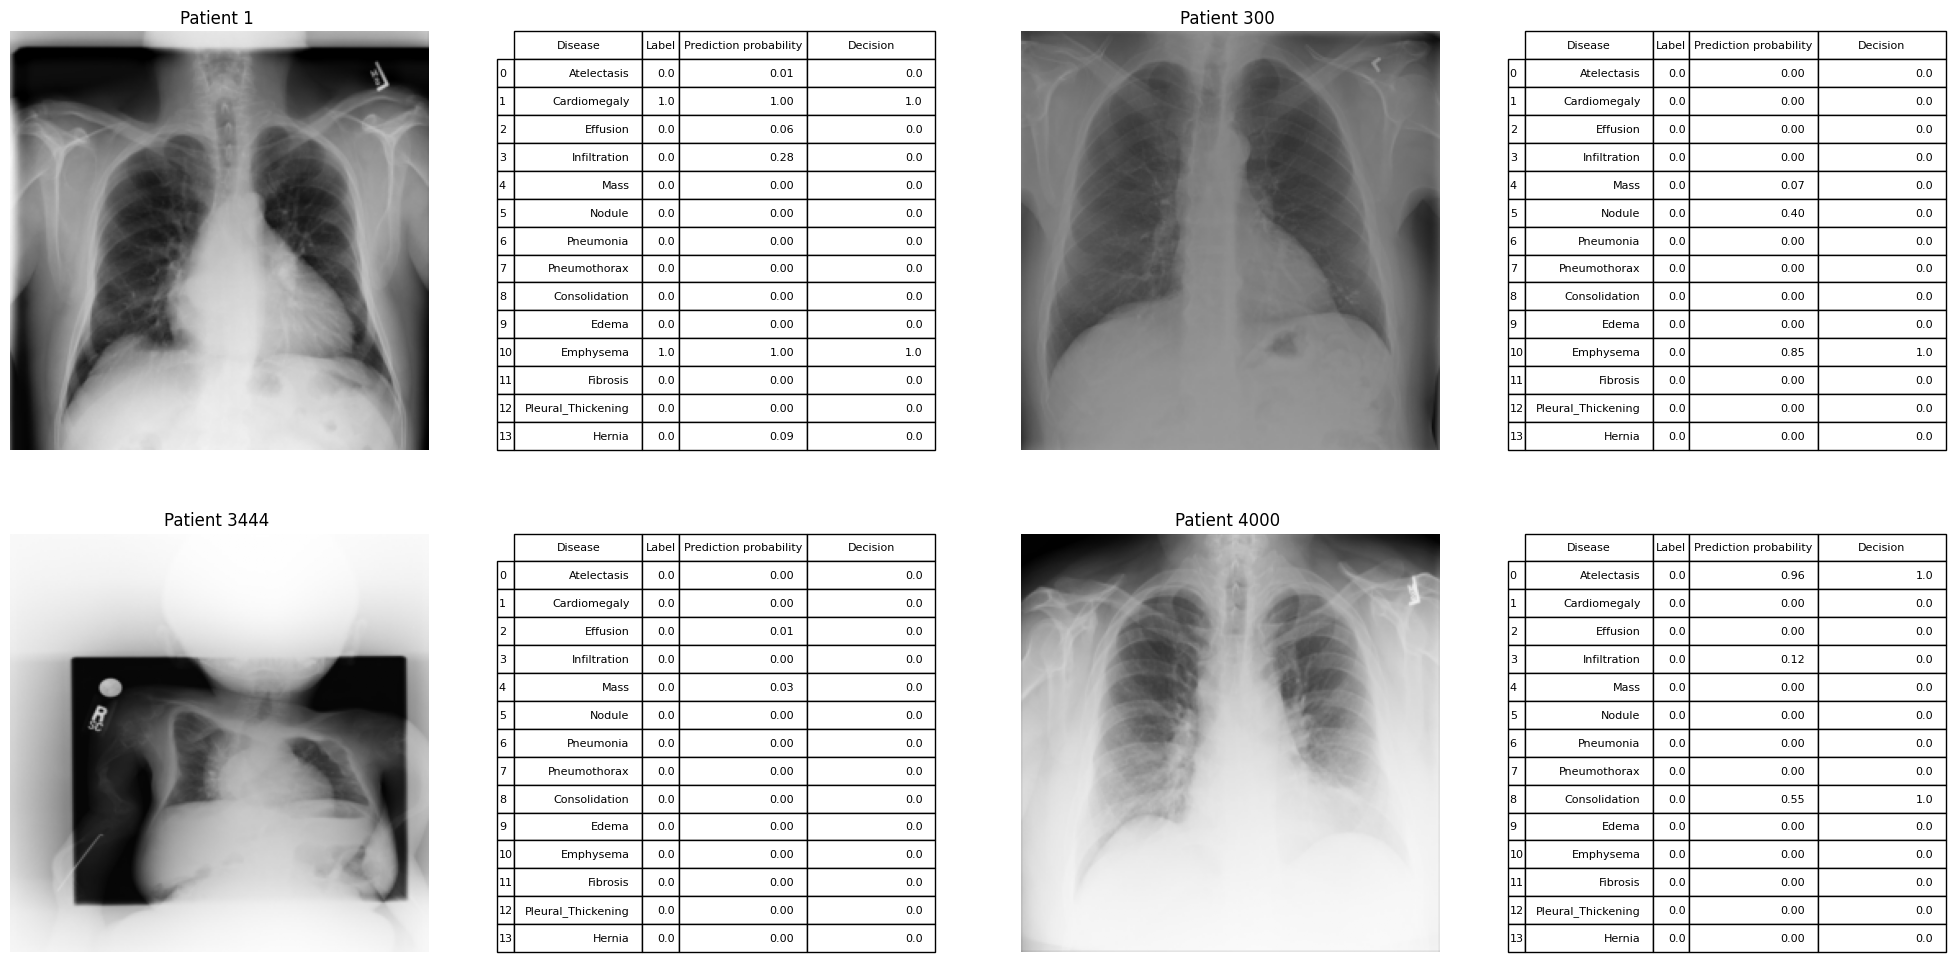

In [12]:
net.eval()
fig = plt.figure(figsize=(25, 25))
patient_ids = [1, 300, 3444, 4000] # arbitrary patient ids picked up as inference examples

for plot_id, inference_id in enumerate(patient_ids):
    # Inference
    image, label = train_data.get_sample(inference_id, normalize_transform)
    image = image.unsqueeze(0).to(device)
    logit = net(image).to(torch.device('cpu')).detach()
    probability = torch.sigmoid(logit).squeeze().numpy()
    out = (probability > 0.5) # Imbalanced training has been taken into consideration.
    
    # Visualisation
    print_img, _ = train_data.get_sample(inference_id, resize_transform) # Image without normalization
    print_img = np.transpose(print_img.numpy(), (1, 2, 0))
    y_true = label.numpy()
        
    df = pd.DataFrame({'Disease': CLASS_NAMES, 'Label': y_true, 'Prediction probability': probability, 'Decision': out})
    df.update(df[['Decision']].applymap('{:,.1f}'.format))
    df.update(df[['Prediction probability']].applymap('{:,.2f}'.format))

    ax1 = fig.add_subplot(len(patient_ids), len(patient_ids), 2 * plot_id+1)
    title = 'Patient %d ' % (inference_id)
    ax1.set_title(title)
    ax1.axis('off')
    plt.imshow(print_img)
    
    ax2 = fig.add_subplot(len(patient_ids), len(patient_ids), 2 * plot_id+2)
    ax2.axis('off')
    table = ax2.table(cellText = df.values, rowLabels = df.index, bbox=[0, 0, 1, 1], colLabels=df.columns)
    table.auto_set_font_size(False)
    table.auto_set_column_width(True)
    table.set_fontsize(8)
    
plt.show()

<a id='multi-gaudi'></a>
## Training on Multiple Gaudis

There are several ways of training models on multiple Gaudi cards. There's [chexnet.py](chexnet.py) python script, which uses almost the same code as this notebook, except there was added performance metric calculation and multi-card training support. In order to run training on multiple cards use a command bellow:

```bash
mpirun -n 8 --bind-to core --map-by socket:PE=6 --rank-by core --report-bindings --allow-run-as-root \
    python chexnet.py \
        --data_dir /.../data --output_dir /.../output \
        --devices 8 \
        --epochs 100 \
        --check_accuracy \
        --training \
        --batch_size 512 \
        --hpu \
        --use_lazy_mode
```

Additional examples showing to use it can be found in [Model Reference](https://github.com/HabanaAI/Model-References/tree/master/PyTorch/nlp/bert#single-card-and-multi-card-pre-training-examples).